In [1]:
#Cài đặt thư viện
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Đọc dữ liệu
df = pd.read_csv("dataset/Data_Uncleaned.csv")
#Tạo file copy, tránh ảnh hưởng data gốc
df_clean = df.copy()

In [3]:
#Kiểm tra dữ liệu
print(df_clean.head())

print(df_clean.info())

print(df_clean.describe())

   Order_ID Gender_Category Product_Line    Product_Name Size  Units_Sold  \
0      2000            Kids     Training     SuperRep Go    M         NaN   
1      2001           Women       Soccer   Tiempo Legend    M         3.0   
2      2002           Women       Soccer     Premier III    M         4.0   
3      2003            Kids    Lifestyle      Blazer Mid    L         NaN   
4      2004            Kids      Running  React Infinity   XL         NaN   

       MRP  Discount_Applied  Revenue  Order_Date Sales_Channel     Region  \
0      NaN              0.47      0.0  2024-03-09        Online  bengaluru   
1  4957.93               NaN      0.0  2024-07-09        Retail        Hyd   
2      NaN               NaN      0.0         NaN        Retail     Mumbai   
3  9673.57               NaN      0.0  04-10-2024        Online       Pune   
4      NaN               NaN      0.0  2024/09/12        Retail      Delhi   

    Profit  
0  -770.45  
1  -112.53  
2  3337.34  
3  3376.85  
4  

In ra thông tin của dữ liệu, kiểm tra số dòng null của từng cột, thống kê mô tả sơ bộ của dữ liệu.

In [4]:
#Xử lý trùng lặp
print(f"Số dòng trùng lặp:{df_clean.duplicated().sum()}")

Số dòng trùng lặp:0


In [5]:
#Xử lý tên cột
    #Xoá khoảng trắng thừa
df_clean.columns = df_clean.columns.str.strip()
    #Chuyển tên cột về dạng snake_case
df_clean.columns=df_clean.columns.str.lower().str.replace(' ','_')


Xử lý tên cột, xoá các khoảng trắng thừa và đưa về dạng snake_case

In [6]:
#Xử lý missing value
print(df_clean.isnull().sum())

order_id               0
gender_category        0
product_line           0
product_name           0
size                 510
units_sold          1235
mrp                 1254
discount_applied    1668
revenue                0
order_date           616
sales_channel          0
region                 0
profit                 0
dtype: int64


Kiểm tra số lượng missing value của từng cột. Có thể thấy các cột mrp (giá niêm yết), units_sold(doanh số), discount_applied(chiết khấu) bị thiếu dữ liệu nhiều nhất. Khi xử lý các cột này cần tuân thủ đúng logic kinh doanh về giá, số lượng, chiết khấu và doanh thu (sẽ trình bày ở bước tiếp theo).

In [7]:
#1.Xử lý cột order_date
date_style_1 = pd.to_datetime(df_clean.order_date, dayfirst=True, errors='coerce')
date_style_2 = pd.to_datetime(df_clean.order_date, format='%Y/%m/%d', errors="coerce")

df_clean.order_date = date_style_1.fillna(date_style_2)

df_clean = df_clean.dropna(subset=['order_date'])

#2.Xử lý cột số lượng:
    #Chuyển số âm thành số dương
df_clean.units_sold = df_clean.units_sold.abs()
    #Xử lý null:
df_clean.units_sold = df_clean.units_sold.fillna(df_clean.units_sold.median())\

#3.Xử lý cột giá niêm yết (MRP)
    #Xử lý null bằng giá trung bình của sản phẩm
df_clean.mrp = df_clean.mrp.replace(0,np.nan)
df_clean.mrp = df_clean.mrp.fillna(df_clean.groupby('product_name')['mrp'].transform('mean'))

#4.Xử lý discount
df_clean.discount_applied = df_clean.discount_applied.fillna(0)
df_clean.loc[(df_clean.discount_applied) > df_clean.mrp,'discount_applied'] = 0

#5.Tính toán lại doanh thu
df_clean['revenue_recalculate'] = df_clean.units_sold * (df_clean.mrp - df_clean.discount_applied)

#Kiểm tra chênh lệch:
df_clean['check_diff'] = df_clean.revenue - df_clean.revenue_recalculate
print('Sai lệch doanh thu trung bình: ', df_clean.check_diff.mean())

#6.Xử lý lỗi chính tả địa lý
df_clean.region = df_clean.region.str.title().str.strip()
df_clean.region = df_clean.region.replace({'Hyd' : 'Hyderabad', 'hyderabad' : 'Hyderabad', 'bengaluru' : 'Bengaluru', 'Bangalore' : 'Bengaluru', 'Dehli' : 'Delhi'})

#7.Xử lý cột size
df_clean['size'] = df_clean['size'].astype(str).str.upper().replace('NAN','Unknown')

Sai lệch doanh thu trung bình:  -8227.2646453909


Thuyết minh quá trình xử lý các giá trị bị null:
1.Cột order_date:
    Ban đầu, tác giả chỉ sử dụng cách xoá các dòng bị thiếu thời gian (do không có thời giant thì không thể thực hiện phân tích chuỗi thời gian được). Tuy nhiên cách này làm mất quá nhiều dữ liệu vì định dạng thời gian của dữ liệu gốc có quá nhiều kiểu (Y/d/m , d/m/Y, ...) nên python sẽ nhận dạng kiểu phổ biến nhất và giữ lại. Vì vậy, tác giả đã sử dụng cách nhận biết từng kiểu định dạng thời gian, sau đó kết hợp các kiểu đó lại để giữ lại được nhiều dữ liệu hơn.
2.Cột units_sold:
    Theo thuyết minh dữ liệu trên nền tảng Kaggle, cột này có các giá trị âm nên tác giả đã tiến hành lấy giá trị tuyệt đối của các giá trị đó. Sau đó tiến hành xử lý giá trị null bằng cách lấy trung vị của cột này để điền vào các giá trị bị thiếu.
3.Cột mrp:
    Theo thuyết minh dữ liệu, cột này có các giá trị 0. Tác giả cho rằng giá niêm yết bằng 0 sẽ không có ý nghĩa, nên đã thay các giá trị 0 bằng NA để xử lý ở bước sau. Các giá trị NA của cột này được thay thế bằng giá trung bình của sản phẩm theo nhóm sản phẩm cùng loại.
4.Cột discount_applied:
    Theo thuyết minh dữ liệu, cột này có các giá trị NA. Tác giả cho rằng các giá trị này xuất hiện do mặt hàng đó không có chiết khấu, vì vậy nên đã thay các giá trị đó bằng 0 (không có chiết khấu được áp dụng). Ngoài ra, cũng theo thuyết minh, cột này có các giá trị lớn hơn 100%. Điều này là vô lý vì chiết khấu luôn phải nhỏ hơn 100%. Vì vậy, tác giả đã thay các giá trị này thành 0 (không có chiết khấu).
5.Cột revenue:
    Đây là cột quan trọng khi phân tích, vì vậy cần xử lý cẩn thận. Theo thuyết minh, cột này có nhiều giá trị bị tính toán sai nên tác giả đã tạo cột mới để tính toán lại theo công thức "Doanh thu = Số lượng *(Giá niêm yết - Phần được chiết khấu)" sau đó kiểm tra lại và tính giá trị sai lệch trung bình để so sánh. Vì sai lệch trung bình lớn nên sẽ thay thế cột doanh thu gốc bằng doanh thu tính lại.
6.Cột region:
    Cột này chứa tên các thành phố của Ấn Độ. Có một số thành phố bị sai chính tả, một số tên thành phố có 2 cách viết, một số tên thành phố vừa sử dụng tên cũ và tên mới. Cần thay đổi thống nhất để thuận tiện và chính xác trong quá trình phân tích.
7.Cột size:
    Có các giá trị bị thiếu, tác giả cho rằng đây là thông tin của các sản phẩm như mũ, khăn,... nên không có thông số kích cỡ. Vì vậy đã thay các giá trị đó thành 'Unknown'

               mrp  units_sold  revenue_recalculate       profit
count   844.000000  844.000000           844.000000   844.000000
mean   6113.529042    1.398104          8450.051494  1389.749100
std    1614.219906    1.045942          6710.643454  1480.468761
min    2010.070000    0.000000             0.000000 -1199.320000
25%    5418.565000    1.000000          5418.565000    85.937500
50%    6112.424783    1.000000          6310.468125  1349.660000
75%    6733.627500    1.000000          9401.792500  2713.487500
max    9996.220000    4.000000         39984.880000  3995.490000
Doanh thu trung bình:  8450.051493732131


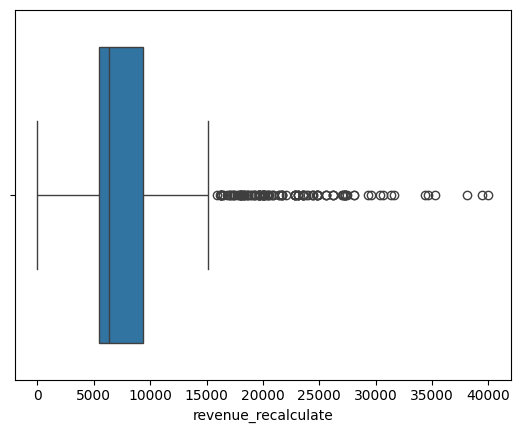

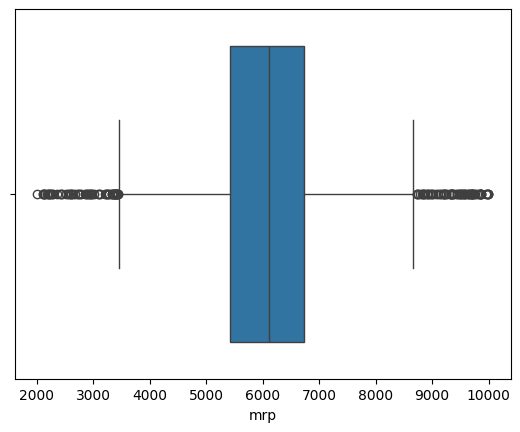

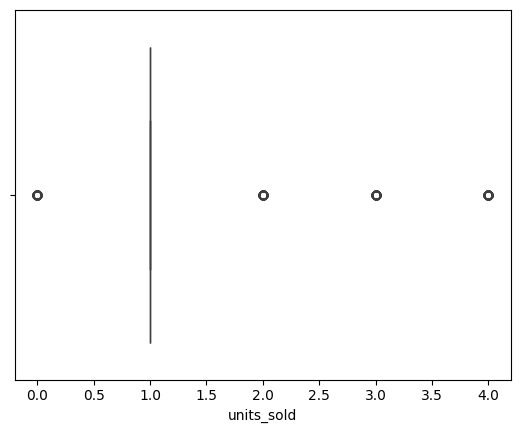

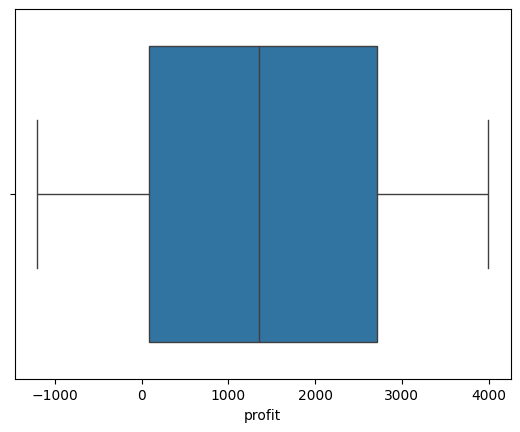

In [8]:
#Kiểm tra outlier
print(df_clean[['mrp', 'units_sold', 'revenue_recalculate','profit']].describe())
print('Doanh thu trung bình: ',df_clean.revenue_recalculate.mean())

# Vẽ Boxplot cho cột revenue
sns.boxplot(x=df_clean['revenue_recalculate'])
plt.show()
# Vẽ Boxplot cho cột mrp
sns.boxplot(x=df_clean['mrp'])
plt.show()
# Vẽ Boxplot cho cột unit_sold
sns.boxplot(x=df_clean['units_sold'])
plt.show()
# Vẽ Boxplot cho cột profit
sns.boxplot(x=df_clean['profit'])
plt.show()

Sau khi làm sạch dữ liệu, tiến hành làm thống kê mô tả và vẽ biểu đồ boxplot để kiểm tra giá trị ngoại lai. Qua quá trình kiểm tra, dữ liệu hoàn toàn bình thường. Có xuất hiện những giá trị ngoại lai nhưng hoàn toàn phù hợp với thực tế kinh doanh nên được giữ lại. Tổng số dòng dữ liệu sạch thu được là 844 dòng.

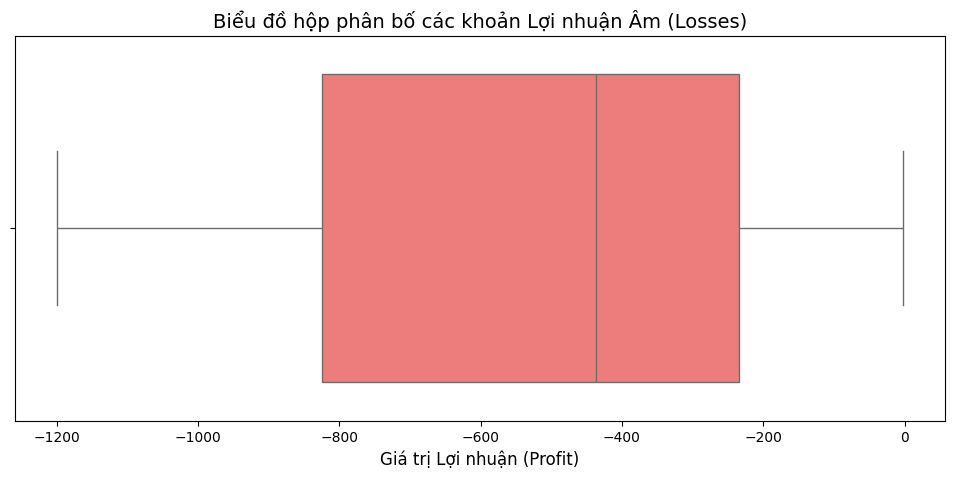

Thống kê chi tiết các khoản lỗ:
count     196.000000
mean     -522.112296
std       352.193338
min     -1199.320000
25%      -825.027500
50%      -436.440000
75%      -233.702500
max        -2.860000
Name: profit, dtype: float64
Thống kê chi tiết doanh thu:
count      196.000000
mean      8571.050433
std       6114.717691
min          0.000000
25%       5666.815357
50%       6310.468125
75%       9487.582500
max      34352.560000
Name: revenue_recalculate, dtype: float64


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Lọc ra các dòng có Lợi nhuận ÂM
df_loss = df_clean[df_clean['profit'] < 0]

# Kiểm tra xem có dữ liệu để vẽ không
if len(df_loss) > 0:
    plt.figure(figsize=(12, 5))
    
    # 2. Vẽ Box Plot
    # Dùng màu đỏ (color='red') để biểu thị cảnh báo/thua lỗ
    sns.boxplot(x=df_loss['profit'], color='#ff6b6b')
    
    plt.title('Biểu đồ hộp phân bố các khoản Lợi nhuận Âm (Losses)', fontsize=14)
    plt.xlabel('Giá trị Lợi nhuận (Profit)', fontsize=12)
    
    # Hiển thị biểu đồ
    plt.show()

    # 3. In kèm thống kê mô tả để bạn dễ đánh giá con số cụ thể
    print("Thống kê chi tiết các khoản lỗ:")
    print(df_loss['profit'].describe())
    print("Thống kê chi tiết doanh thu:")
    print(df_loss['revenue_recalculate'].describe())
else:
    print("Tuyệt vời! Không tìm thấy khoản lỗ (lợi nhuận âm) nào trong dữ liệu.")

Qua kiểm tra nhận thấy xuất hiện một số giá trị âm ở cột profit nên tiến hành kiểm tra lại. Kết quả cho thấy giá trị trung bình của các khoản lỗ so với doanh thu là phù hợp với thực tế kinh doanh. Có thể kết luận đây là lợi nhuận từ các đợt xả hàng cắt lỗ của doanh nghiệp nên các dữ liệu này được giữ lại.

In [9]:
df_final = df_clean[(df_clean['revenue_recalculate'] >0 ) & (df_clean['units_sold'] > 0)]


In [10]:
(df['Order_Date'].isnull()).sum()


np.int64(616)

In [11]:
df_clean.describe()

,order_id,units_sold,mrp,discount_applied,revenue,order_date,profit,revenue_recalculate,check_diff
count,844.000000,844.000000,844.000000,844.000000,844.000000,844,844.000000,844.000000,844.000000
mean,3191.836493,1.398104,6113.529042,0.210379,222.786848,2024-12-06 05:01:59.431279360,1389.749100,8450.051494,-8227.264645
min,2000.000000,0.000000,2010.070000,0.000000,-7561.590000,2023-01-08 00:00:00,-1199.320000,0.000000,-39984.880000
25%,2538.750000,1.000000,5418.565000,0.000000,0.000000,2024-09-12 00:00:00,85.937500,5418.565000,-9383.797500
50%,3172.500000,1.000000,6112.424783,0.000000,0.000000,2024-12-16 00:00:00,1349.660000,6310.468125,-6242.924348
75%,3824.250000,1.000000,6733.627500,0.322500,0.000000,2025-04-07 06:00:00,2713.487500,9401.792500,-5357.150500
max,4493.000000,4.000000,9996.220000,1.250000,26105.370000,2025-12-04 00:00:00,3995.490000,39984.880000,0.000000
std,748.814528,1.045942,1614.219906,0.364124,1784.821882,NaN,1480.468761,6710.643454,6635.805817


In [12]:
df_final.describe()

,order_id,units_sold,mrp,discount_applied,revenue,order_date,profit,revenue_recalculate,check_diff
count,769.000000,769.000000,769.000000,769.000000,769.000000,769,769.000000,769.000000,769.000000
mean,3200.582575,1.534460,6103.662010,0.207659,244.515085,2024-12-07 12:47:45.019505920,1389.119428,9274.178753,-9029.663668
min,2000.000000,1.000000,2010.070000,0.000000,-7561.590000,2023-01-08 00:00:00,-1199.320000,2010.070000,-39984.880000
25%,2539.000000,1.000000,5418.565000,0.000000,0.000000,2024-09-12 00:00:00,66.430000,5767.462000,-9699.010000
50%,3189.000000,1.000000,6112.424783,0.000000,0.000000,2024-12-16 00:00:00,1326.670000,6562.256000,-6561.646000
75%,3858.000000,2.000000,6743.070000,0.310000,0.000000,2025-04-07 00:00:00,2762.680000,9713.730000,-5705.893810
max,4493.000000,4.000000,9996.220000,1.250000,26105.370000,2025-12-04 00:00:00,3995.490000,39984.880000,-139.340000
std,752.865226,0.995653,1612.438909,0.364436,1868.518676,NaN,1504.043901,6463.544553,6409.311884


In [14]:
df_final = df_final.drop(columns=['revenue','check_diff'],errors= 'ignore')
df_final = df_final.rename(columns={'revenue_recalculate':'revenue'})

cols = ['order_id', 'order_date', 'product_name', 'product_line', 'size', 
        'units_sold', 'mrp', 'discount_applied', 'revenue', 'profit', 
        'region', 'gender_category', 'sales_channel']
df_final = df_final[[c for c in cols if c in df_final.columns]]

df_final.to_csv('dataset/Data_Cleaned.csv',index= False)
print(f"Kích thước file cuối cùng: {df_final.shape}")

Kích thước file cuối cùng: (769, 13)
